In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline

%matplotlib inline

beers = pd.read_csv(
    "https://raw.githubusercontent.com/dlsun/data-science-book/master/data/beer/beer_train.csv"
)
beers_test = pd.read_csv(
    "https://raw.githubusercontent.com/dlsun/data-science-book/master/data/beer/beer_test.csv"
)
beers.srm = beers.srm.str.replace('Over 40', '41').astype(int)
beers.head()

,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,0,8.2,"Available at the same time of year, every year.",A Belgian-Abbey-Style Tripel that is big in al...,NaN,31.0,N,LoonyToonTripel,1.070,8
1,1,5.7,"Available at the same time of year, every year.",Covert Hops is a crafty ale. Its stealthy dark...,Pint,45.0,N,Covert Hops,1.056,35
2,2,5.8,"Available at the same time of year, every year.",This is a traditional German-style Marzen char...,Mug,25.0,N,Oktoberfest,1.048,10
3,3,5.5,Available year round as a staple beer.,A West Coast-Style Pale Ale balancing plenty o...,Pint,55.0,N,Pale Ale,1.044,5
4,4,4.8,Available year round as a staple beer.,This Bombshell has a tantalizing crisp and cle...,Pint,11.4,N,Head Turner Blonde Ale,1.045,3


In [2]:
beers_test.srm = beers_test.srm.str.replace('Over 40', '41').astype(int)
beers_test.head()

,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,6000,10.0,Limited availability.,A classic Belgian Trappist style strong ale wi...,Tulip,NaN,N,She WILL!,1.084,17
1,6001,5.2,Available year round as a staple beer.,An American-style of Pale Ale brewed with a ba...,Pint,NaN,N,Defender American Pale Ale,1.044,22
2,6002,4.0,Available during the winter months.,"This amber wheat ale has a balanced malt body,...",Tulip,NaN,Y,Hazel,1.036,19
3,6003,10.2,Available year round as a staple beer.,A uniquely large beer developed by taking our ...,Pint,NaN,N,Cinderella’s Twin Double IPA,1.087,11
4,6004,6.0,Limited availability.,An American red ale with crisp hop flavor.,NaN,NaN,N,Independence Ale,1.048,14


In [3]:
#Best feature from 5A
features1 = ["abv", "isOrganic", "srm", "originalGravity"]

#Text Features
features2 = "description"
features3 = "available"
features4 = "glass"

In [4]:
x = beers[features2].fillna("")
y = beers["ibu"]

#For Training with Textual Data
def pipe_and_train_text(x, y, n1, n2): 
    pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(n1, n2))),
        ('tfidf', TfidfTransformer()),
        ('knn', KNeighborsRegressor()),
    ])

    scores = cross_val_score(pipeline, x, y, 
                                 cv=5, scoring="neg_mean_squared_error")
    return np.sqrt(np.mean(-scores))

print("Description (N-grams of 1): ", end='')
pipe_and_train_text(x, y, 1, 1)

Description (N-grams of 1): 

32.37961166227137

In [5]:
print("Description (N-grams of 2,3): ", end='')
pipe_and_train_text(x, y, 2, 3)

Description (N-grams of 2,3): 

32.29939521063565

In [6]:
x = beers[features3]
print("Availability (N-grams of 1): ", end='')
pipe_and_train_text(x, y, 1, 1)

Availability (N-grams of 1): 

30.31617494736927

In [7]:
x = beers[features3]
print("Availability (N-grams of 2,3): ", end='')
pipe_and_train_text(x, y, 2, 3)

Availability (N-grams of 2,3): 

29.47777944214082

In [8]:
x = beers[features2].fillna("")  + beers[features3]
print("Description + Availability (N-grams of 1): ", end='')
pipe_and_train_text(x, y, 1, 1)

Description + Availability (N-grams of 1): 

25.4605691865292

In [9]:
print("Description + Availability (N-grams of 1, 2): ", end='')
pipe_and_train_text(x, y, 1, 2)

Description + Availability (N-grams of 1, 2): 

30.911666411505006

In [10]:
x = (beers[features2].fillna("") + 
     beers[features3] + 
     beers[features4].fillna("") )
print("Description + Availability + Glass (N-grams of 1): ", end='')
pipe_and_train_text(x, y, 1, 1)

Description + Availability + Glass (N-grams of 1): 

27.032879559727014

In [11]:
print("Description + Availability + Glass (N-grams of 1, 2): ", end='')
pipe_and_train_text(x, y, 1, 2)

Description + Availability + Glass (N-grams of 1, 2): 

32.74267585170002

In [12]:
#Generic Series Creator
def set_series(start, end, increment=1, type="int"):
    temp = list(range(start, end, increment))
    series = pd.Series(temp)
    series = series.reindex(temp)
    for x in temp:
        series[x] = x
    
    if type is "int":
        return series.astype(int)
    else:
        return series

#Generic Pipe and Train for all Future Models
def pipe_and_train(vec, scaler, model):
    features = features1
    x_dict = beers[features].to_dict(orient="records")
    y = beers["ibu"]
    pipeline = Pipeline([
        ("vectorizer", vec), 
        ("scaler", scaler), 
        ("fit", model)])
    scores = cross_val_score(pipeline, x_dict, y, 
                             cv=5, scoring="neg_mean_squared_error")
    return np.sqrt(np.mean(-scores))



10.0
20.0
30.0
40.0


(10, 24.948643157052384)

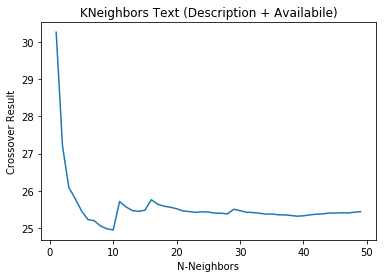

In [17]:
#Description and Availability Seems Promising
def try_desc_available_nneighbor(k):
    if (k % 10) == 0:
        print(str(k))
    x = beers[features2].fillna("")  + beers[features3]
    y = beers["ibu"]
    n1 = 1
    n2 = 1
    pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(n1, n2))),
        ('tfidf', TfidfTransformer()),
        ('knn', KNeighborsRegressor(n_neighbors=int(round(k)))),
    ])

    scores = cross_val_score(pipeline, x, y, 
                                 cv=5, scoring="neg_mean_squared_error")
    return np.sqrt(np.mean(-scores))

desc_available_series = set_series(1, 50, type="float")
desc_available_series = desc_available_series.apply(
    try_desc_available_nneighbor)
min_neighbor = desc_available_series.idxmin()
plt.title("KNeighbors Text (Description + Availabile)")
plt.xlabel("N-Neighbors")
plt.ylabel("Crossover Result")
desc_available_series.plot.line()
(desc_available_series.idxmin(),  desc_available_series.min())

In [18]:
######## Bayesian Ridge ##############

#Standard Run 
(pipe_and_train(
    DictVectorizer(sparse=False), 
    StandardScaler(), 
    BayesianRidge()))

25.87396103622714

(1, 25.866488522140752)

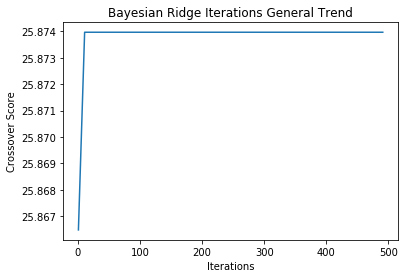

In [19]:
def try_br_niter(k):
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        BayesianRidge(
            n_iter=int(round(k)))))

#Look for general overall trend in relation to alpha value
br_niter_series = set_series(1, 501, 10, type="float")
br_niter_series = br_niter_series.apply(try_br_niter)
plt.title("Bayesian Ridge Iterations General Trend")
plt.xlabel("Iterations")
plt.ylabel("Crossover Score")
br_niter_series.plot.line()
(br_niter_series.idxmin(), br_niter_series.min())

(1, 25.866488522140752)

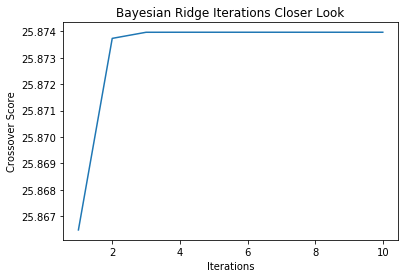

In [20]:
#Bayesian Ridge 1 - 10 iterations
br_niter_series10 = set_series(1, 11, type="float")
br_niter_series10 = br_niter_series10.apply(try_br_niter)
plt.title("Bayesian Ridge Iterations Closer Look")
plt.xlabel("Iterations")
plt.ylabel("Crossover Score")
br_niter_series10.plot.line()
min_br_iter = br_niter_series10.idxmin()
(br_niter_series10.idxmin(), br_niter_series10.min())

(0, 25.866488522140752)

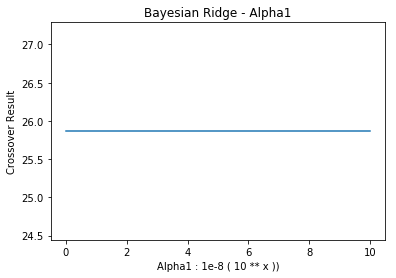

In [25]:
def try_br_alpha1(k):
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        BayesianRidge(
            n_iter=min_br_iter, 
            alpha_1=k)))

temp = list(range(0, 11))
br_alpha1_series = pd.Series().reindex(temp)
for x in temp:
    temp[x] = 1e-8 * (10 ** x)
i = 0
for x in temp:
    br_alpha1_series[i] = x
    i += 1
br_alpha1_series = br_alpha1_series.apply(try_br_alpha1)
plt.title("Bayesian Ridge - Alpha1")
plt.xlabel("Alpha1 : 1e-8 ( 10 ** x ))")
plt.ylabel("Crossover Result")
br_alpha1_series.plot.line()
min_alpha1 = 1e-8 * ( 10 ** br_alpha1_series.idxmin()) 
(br_alpha1_series.idxmin(), br_alpha1_series.min())

(0, 25.866488522140752)

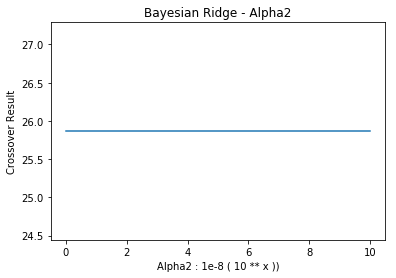

In [27]:
def try_br_alpha2(k):
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        BayesianRidge(n_iter=min_br_iter, 
                      alpha_1=min_alpha1, 
                      alpha_2=k)))

temp = list(range(0, 11))
br_alpha2_series = pd.Series().reindex(temp)
for x in temp:
    temp[x] = 1e-8 * (10 ** x)
i = 0
for x in temp:
    br_alpha2_series[i] = x
    i += 1
br_alpha2_series = br_alpha2_series.apply(try_br_alpha2)
plt.title("Bayesian Ridge - Alpha2")
plt.xlabel("Alpha2 : 1e-8 ( 10 ** x ))")
plt.ylabel("Crossover Result")
br_alpha2_series.plot.line()
min_alpha2 = 1e-8 * ( 10 ** br_alpha2_series.idxmin()) 
(br_alpha2_series.idxmin(), br_alpha2_series.min())

(0, 25.866488522140752)

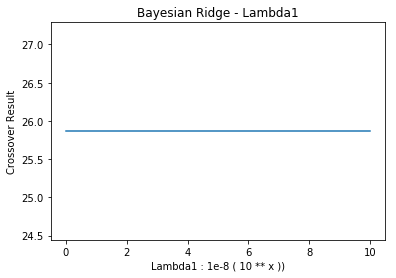

In [30]:
def try_br_lambda1(k):
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        BayesianRidge(n_iter=min_br_iter, 
                      alpha_1=min_alpha1, 
                      alpha_2=min_alpha2, 
                      lambda_1 = k)))

temp = list(range(0, 11))
br_lambda1_series = pd.Series().reindex(temp)
for x in temp:
    temp[x] = 1e-8 * (10 ** x)
i = 0
for x in temp:
    br_lambda1_series[i] = x
    i += 1
br_lambda1_series = br_lambda1_series.apply(try_br_lambda1)
plt.title("Bayesian Ridge - Lambda1")
plt.xlabel("Lambda1 : 1e-8 ( 10 ** x ))")
plt.ylabel("Crossover Result")
br_lambda1_series.plot.line()
min_lambda1 = 1e-8 * ( 10 ** br_lambda1_series.idxmin()) 
(br_lambda1_series.idxmin(), br_lambda1_series.min())

Begin Training
1.0 
2.0 
3.0 
4.0 
5.0 


(1, 25.97399865315704)

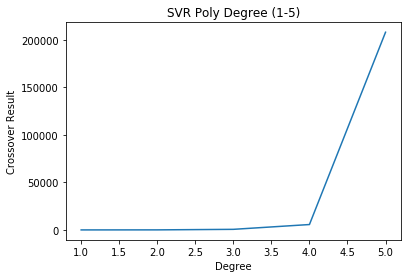

In [31]:
####### SVR #############
def try_svr_poly_deg(k):
    print(str(k) + " ")
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        SVR(
            kernel="poly", 
            degree=int(round(k)))))


svr_poly_series = set_series(1, 6, type="float")
print("Begin Training")
svr_poly_series = svr_poly_series.apply(try_svr_poly_deg)
plt.title("SVR Poly Degree (1-5)")
plt.xlabel("Degree")
plt.ylabel("Crossover Result")
svr_poly_series.plot.line()
(svr_poly_series.idxmin(), svr_poly_series.min())

In [32]:
#SVR RBF
(pipe_and_train(
    DictVectorizer(sparse=False), 
    StandardScaler(), 
    SVR()))

24.39396805843456

In [33]:
####### Kmeans from 5A ###########
(pipe_and_train(
    DictVectorizer(sparse=False), 
    StandardScaler(), 
    KNeighborsRegressor(
        n_neighbors=16, 
        metric='manhattan')))

22.513349808104554

In [34]:
######## Gaussian Process Regressor ##########

print_iteration = 1
def try_gpr_alpha(k):
    if (k % print_iteration) == 0:
        print(str(k) + " ")
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        GaussianProcessRegressor(alpha=k)))

Begin Training: 
1.0 
10.0 
100.0 
1000.0 
10000.0 
100000.0 
1000000.0 


(1.0, 23.826371565651307)

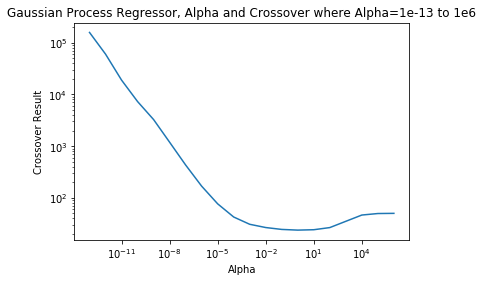

In [35]:
temp = list(range(0,20))
for x in temp:
    temp[x] = 1e-13 * (10 ** x)


gpr_alpha_series = pd.Series(temp)
gpr_alpha_series = gpr_alpha_series.reindex(temp)
for x in temp:
    gpr_alpha_series[x] = x


print("Begin Training: ")
gpr_alpha_series = gpr_alpha_series.apply(try_gpr_alpha)
plt.title("Gaussian Process Regressor, Alpha and Crossover where Alpha=1e-13 to 1e6")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Alpha")
plt.ylabel("Crossover Result")
gpr_alpha_series.plot.line()
(gpr_alpha_series.idxmin(), gpr_alpha_series.min())

Begin Training: 
1.0 
2.0 
3.0 
4.0 
5.0 
6.0 
7.0 
8.0 
9.0 
10.0 


(1.5, 23.805646831537192)

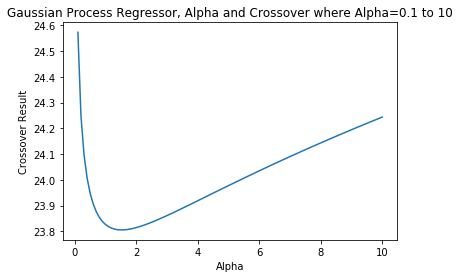

In [39]:
#Closer look at Gaussian Process Regressor dip (0.1 to 10)
temp = list(range(1, 101))
i = 0
for x in temp:
    temp[i] = round(x * 0.1, 1)
    i += 1
    
gpr_alpha_series2 = pd.Series()
gpr_alpha_series2 = gpr_alpha_series2.reindex(temp)
for x in temp:
    gpr_alpha_series2[x] = x

print_iteration = 1
print("Begin Training: ")
gpr_alpha_series2 = gpr_alpha_series2.apply(try_gpr_alpha)
plt.title("Gaussian Process Regressor, Alpha and Crossover where Alpha=0.1 to 10")
plt.xlabel("Alpha")
plt.ylabel("Crossover Result")
gpr_alpha_series2.plot.line()
(gpr_alpha_series2.idxmin(), gpr_alpha_series2.min())

C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochasti

C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochasti

(1100, 23.548392486379903)

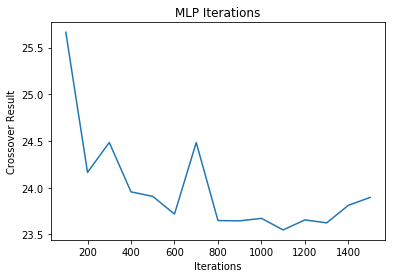

In [40]:
######## MLP Regressor #############
def try_mlp_iteration(k):
    return pipe_and_train(DictVectorizer(sparse=False), StandardScaler(), MLPRegressor(max_iter=int(round(k))))

mlp_iteration_series = set_series(100, 1501, 100, type="float")
mlp_iteration_series = mlp_iteration_series.apply(try_mlp_iteration)

plt.title("MLP Iterations")
plt.xlabel("Iterations")
plt.ylabel("Crossover Result")
mlp_iteration_series.plot.line()
min_iteration = mlp_iteration_series.idxmin()
(mlp_iteration_series.idxmin(), mlp_iteration_series.min())

10.0


C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stocha

20.0


C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stocha

30.0


C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stocha

40.0


C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


50.0


C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


60.0
70.0


C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


80.0


C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\James\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


90.0
100.0
110.0
120.0
130.0
140.0
150.0


(110, 23.61793128895831)

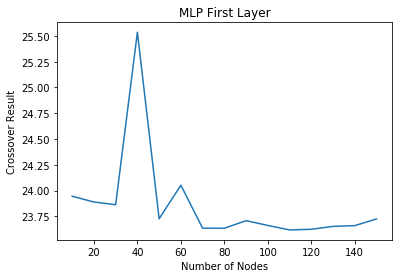

In [41]:
def mlp_first_layer_tuning(k):
    print(str(k))
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        MLPRegressor(
            hidden_layer_sizes=(int(round(k)),), 
            max_iter=min_iteration)))

mlp_layer1_series = set_series(10, 151, 10, type="float")
mlp_layer1_series = mlp_layer1_series.apply(mlp_first_layer_tuning)

plt.title("MLP First Layer")
plt.xlabel("Number of Nodes")
plt.ylabel("Crossover Result")
mlp_layer1_series.plot.line()
layer1 = mlp_layer1_series.idxmin()
(mlp_layer1_series.idxmin(), mlp_layer1_series.min())

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


(110, 23.44467564525101)

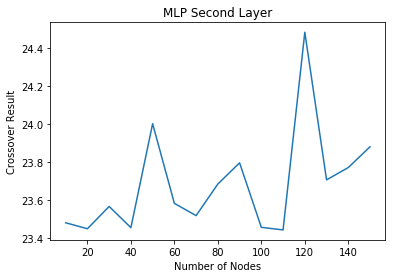

In [42]:
def mlp_second_layer_tuning(k):
    print(str(k))
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        MLPRegressor(
            hidden_layer_sizes=(layer1,int(round(k)),), 
            max_iter=min_iteration)))

mlp_layer2_series = set_series(10, 151, 10, type="float")
mlp_layer2_series = mlp_layer2_series.apply(mlp_second_layer_tuning)

plt.title("MLP Second Layer")
plt.xlabel("Number of Nodes")
plt.ylabel("Crossover Result")
mlp_layer2_series.plot.line()
layer2 = mlp_layer2_series.idxmin()
(mlp_layer2_series.idxmin(), mlp_layer2_series.min())

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0


(50, 22.90357260414599)

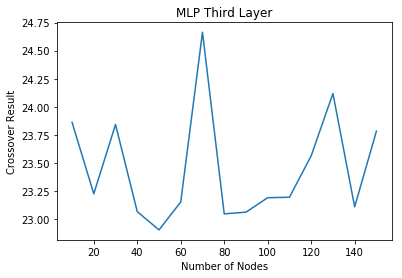

In [43]:
def mlp_third_layer_tuning(k):
    print(str(k))
    return (pipe_and_train(
        DictVectorizer(sparse=False), 
        StandardScaler(), 
        MLPRegressor(
            hidden_layer_sizes=(layer1, layer2, int(round(k)),), 
            max_iter=min_iteration)))

mlp_layer3_series = set_series(10, 151, 10, type="float")
mlp_layer3_series = mlp_layer3_series.apply(mlp_third_layer_tuning)

plt.title("MLP Third Layer")
plt.xlabel("Number of Nodes")
plt.ylabel("Crossover Result")
mlp_layer3_series.plot.line()
layer3 = mlp_layer3_series.idxmin()
(mlp_layer3_series.idxmin(), mlp_layer3_series.min())

In [46]:
#result model used for prediction & result
def predict(vec, scaler, model):
    features = features1
    x_dict_train = beers[features].to_dict(orient="records")
    x_dict = beers_test[features].to_dict(orient="records")
    y = beers["ibu"]
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    pipeline.fit(x_dict_train, y)
    result = pipeline.predict(x_dict)
    resultdf = pd.DataFrame()
    resultdf["id"] = beers_test["id"].copy()
    i = 0
    for x in result:
        resultdf.loc[i, "ibu"] = x
        i += 1
    resultdf.set_index("id").to_csv("C:/Users/James/Downloads/predictions.csv")

predict(DictVectorizer(sparse=False),
       StandardScaler(), 
       MLPRegressor(
            hidden_layer_sizes=(layer1, layer2, layer3,), 
            max_iter=min_iteration))

I first started out with textual data. I went through a few combinations of combining different textual data (Description, Available, Glass) as well as differnt n-grams. The most promising one was the combination of Description and Available with just 1 gram. I conducted hyperparameter tuning with k-neighbors regression. The result came out to be a crossover score of 24.9. This was not close to the k-means result I've gotten in 5A with just the quantitative variables. I was not able to figure out how to combine the two different types of data so I went along with the quantatative variables, which seemed to be a better representation. 

I moved on to a different model, Bayesian Ridge. When first running the training data set through the model, I received a score of 25.87. I tried to lower the score by tuning the number of iterations. It was able to reduce the score to 25.86, so I tried tuning other parameters. I tried tuning alpha1, alpha2, and lambda1. None of them changed the result. Ths result was still not close to the k-neighbors result. 

I tried using the Support Vector Regression (SVR). I tried out the polynomial aspect and tuned the degrees parameter. The cost of training was incredibly high. I ran degrees 1 to 10 and was not able to finish the training after 3 days. 

The next model I used was the Gaussian Process Regressor. I infered that it was related to the Gaussian formula and thought the alpha parameter would be important in fitting the model to the data set; hence I tuned alpha. I started out with the big picture. The default alpha value scikit learn provides is 1e-10, so I decided to conduct the tuning in a range that included 1e-10. 1e-15 gave me an error so I used the range 1e-13 to 1e6. This gave me a curve like when tuning k-neighbors. I looked closer at the area of interest (the dip) to see if I can get a more specific alpha and minimumm score. I used the range 0.1 to 10 with increments of 0.1. The result was having an alpha of 1.5 and a score of 23.8. On my local machine, I tried adjusting the n_restards_optimizer parameter, but no change came out of it so I didn't include it in the report. 

I then checked out Multi-Layer Perceptron (MLP). I determined the number of iterations to use first, and then tried seeing how many nodes each layer should have and how many layers the model should have. I read here (https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) about choosing the number of layers and nodes. The most I got out of it was that usually 1 layer would suffice, making me expect a low number of layers. I tested layer by layer. There were several issues when using this model. One was I kept getting warnings making my output messy. Another was that the result of training changes each time I run it. For example, on my laptop I tuned iterations multiple times and each time produced a different but similar result. In the end, I reach the third layer with my results being 22.90, closest to the k-neighbors value I had before. 

As a result, none of the models I chose were able to beat the k-neighbors model so I decided to use that one as my submission to Kaggle.